# Select suitable MDL test: KVLCC2 **at** speed

# Purpose
Find suitable roll decay tests from MDL, to reproduce in Motions later on.

# Methodology
Look at the results from the KLVCC2 ship.
* Load model tests from MDL
* Determine damping

# WIP - improvements
(WORK IN PROGRESS)
Use this section only if the notebook is not final.

Notable TODOs:
* todo 1
* todo 2
* todo 3

## Results
Describe and comment the most important results.

# Suggested next steps
State suggested next steps, based on results obtained in this notebook.

# Setup

In [1]:
# %load imports.py
"""
These is the standard setup for the notebooks.
"""

%matplotlib inline
%load_ext autoreload
%autoreload 2

from jupyterthemes import jtplot
jtplot.style(theme='onedork', context='notebook', ticks=True, grid=False)

import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option("display.max_columns", None)
import numpy as np
import os
import matplotlib.pyplot as plt
from collections import OrderedDict
#plt.style.use('paper')

#import data
import copy
from mdldb.run import Run

from sklearn.pipeline import Pipeline
from rolldecayestimators.transformers import CutTransformer, LowpassFilterDerivatorTransformer, ScaleFactorTransformer, OffsetTransformer
from rolldecayestimators.direct_estimator_cubic import EstimatorQuadraticB, EstimatorCubic
from rolldecayestimators.ikeda_estimator import IkedaQuadraticEstimator
import rolldecayestimators.equations as equations
import rolldecayestimators.lambdas as lambdas
from rolldecayestimators.substitute_dynamic_symbols import lambdify
import rolldecayestimators.symbols as symbols
import sympy as sp

from sklearn.metrics import r2_score
from src.data import database
from mdldb import tables


Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 461 ('figure.figsize   : 5, 3   ## figure size in inches')
Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 462 ('figure.dpi       : 100        ## figure dots per inch')


In [2]:
from mdldb.hdf5_file import Hdf5File
from rolldecayestimators.direct_estimator_cubic import EstimatorCubic,EstimatorQuadraticB
from sklearn.base import clone
from copy import deepcopy
from sklearn.metrics import mean_absolute_error
import joblib

In [3]:
db = database.get_db()

In [4]:
sql = """
SELECT * from run
WHERE model_number='M5057-01-A' and test_type='roll decay' and project_number=40178362;
"""
df_rolldecays = pd.read_sql(sql=sql, con=db.engine, index_col='id')

df_rolldecays['ship_speed'].fillna(0, inplace=True)


In [5]:
df_rolldecays

,project_number,series_number,run_number,test_number,model_number,ship_name,loading_condition_id,ascii_name,ship_speed,comment,file_path_ascii,file_path_ascii_temp,file_path_log,file_path_hdf5,date,test_type,facility,angle1,angle2,Körfallstyp
id,,,,,,,,,,,,,,,,,,,,
21337,40178362,1,94,1,M5057-01-A,M5057-01-A,166,94.0,0.0,"Roll decay, 0 kn",NaN,None,\\sspa.local\gbg\LABmeasuredataMDL\40178362\00...,\\sspa.local\gbg\LABmeasuredataMDL\40178362\00...,2018-04-03,roll decay,MDL,None,None,None
21338,40178362,1,95,1,M5057-01-A,M5057-01-A,166,95.0,0.0,"Roll decay, 0 kn",NaN,None,\\sspa.local\gbg\LABmeasuredataMDL\40178362\00...,\\sspa.local\gbg\LABmeasuredataMDL\40178362\00...,2018-04-03,roll decay,MDL,None,None,None
21339,40178362,1,96,1,M5057-01-A,M5057-01-A,166,96.0,0.0,"Roll decay, 0 kn",NaN,None,\\sspa.local\gbg\LABmeasuredataMDL\40178362\00...,\\sspa.local\gbg\LABmeasuredataMDL\40178362\00...,2018-11-28,roll decay,MDL,None,None,None
21340,40178362,1,97,1,M5057-01-A,M5057-01-A,166,97.0,15.5,"Roll decay, 15.5 kn",NaN,None,\\sspa.local\gbg\LABmeasuredataMDL\40178362\00...,\\sspa.local\gbg\LABmeasuredataMDL\40178362\00...,2018-04-04,roll decay,MDL,None,None,None


In [6]:
df_rolldecays[['date','ship_speed']]

,date,ship_speed
id,,
21337,2018-04-03,0.0
21338,2018-04-03,0.0
21339,2018-11-28,0.0
21340,2018-04-04,15.5


In [7]:
run_ids = [21340,]
df_rolldecays=df_rolldecays.loc[run_ids].copy()

c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:106: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units


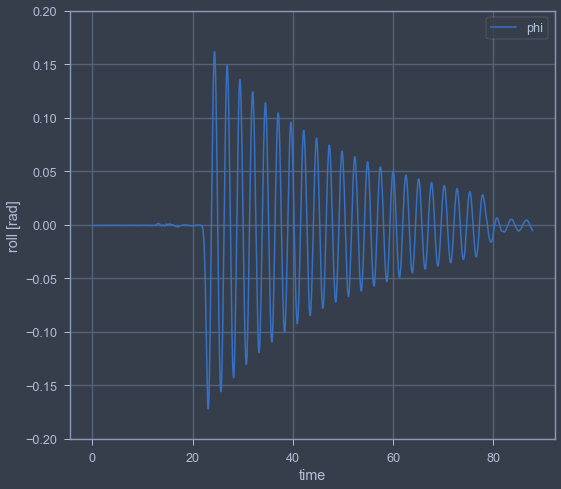

In [8]:
fig,axes=plt.subplots(nrows=len(df_rolldecays))
axes=[axes]

for (id, row),ax in zip(df_rolldecays.iterrows(),axes):

    run = db.session.query(Run).get(int(id))
    run = database.load_run(run, save_as_example=False, prefer_hdf5=True)
    
    run.df.plot(y='phi', ax=ax)
    ax.set_ylabel(f"roll [{run.units['phi']}]")
    ax.grid(True)
    ax.set_ylim([-0.2,0.2])
    
plt.tight_layout()

In [9]:
np.rad2deg(run.df['phi'].abs().max())

9.855

<a id='yawrate'></a>

c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:106: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units


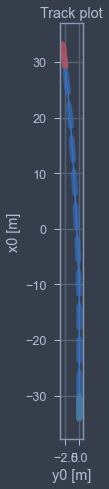

In [10]:
fig,axes=plt.subplots(ncols=len(df_rolldecays))
axes=[axes]
for (id, row),ax in zip(df_rolldecays.iterrows(),axes):

    run = db.session.query(Run).get(int(id))
    run = database.load_run(run, save_as_example=False, prefer_hdf5=True)
    
    run.track_plot(ax)
    
plt.tight_layout()

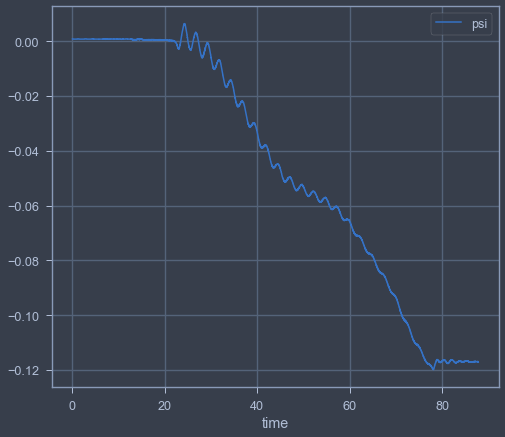

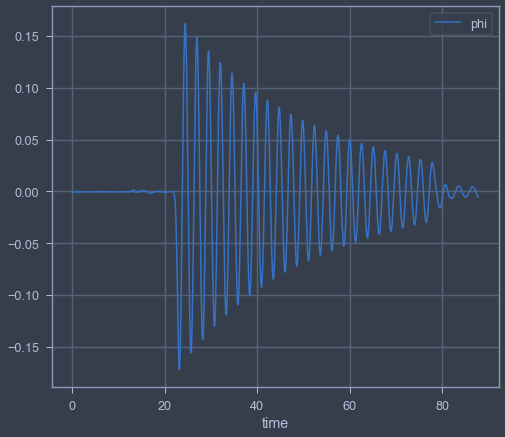

In [11]:
fig,ax=plt.subplots()
df = run.df.copy()
df['psi']=np.unwrap(df['modelpos/yawm'])

df.plot(y='psi', style='-', ax=ax)
ax.grid(True)

fig,ax=plt.subplots()
df.plot(y='phi', style='-', ax=ax)
ax.grid(True)

## Analyze the damping

In [12]:
#run = db.session.query(Run).get(21338)
#run = db.session.query(Run).get(21339)
run = db.session.query(Run).get(run_ids[0])

#run = db.session.query(Run).get(21340)

	
run = database.load_run(run, save_as_example=False, prefer_hdf5=True)

c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:106: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units


In [13]:
lowpass_filter = LowpassFilterDerivatorTransformer(cutoff=1, minimum_score=0.999)
cutter = CutTransformer(phi_max=np.deg2rad(15), phi_min=np.deg2rad(2), phi1d_start_tolerance=0.015)
offset_transformer = OffsetTransformer()

## Offset?

In [14]:
steps = [
    ('filter',lowpass_filter),
    ('cutter', cutter), 
]

pipline_preprocess_1 = Pipeline(steps=steps)

steps = [
    ('filter',lowpass_filter),
    ('cutter', cutter), 
    ('offset_transformer',offset_transformer),
]

pipline_preprocess_2 = Pipeline(steps=steps)

In [16]:
pipline_preprocess_1.fit(X=run.df)
X = pipline_preprocess_1.transform(X=run.df)

pipline_preprocess_2.fit(X=run.df)
X_trans = pipline_preprocess_2.transform(X=run.df)

<AxesSubplot:xlabel='time'>

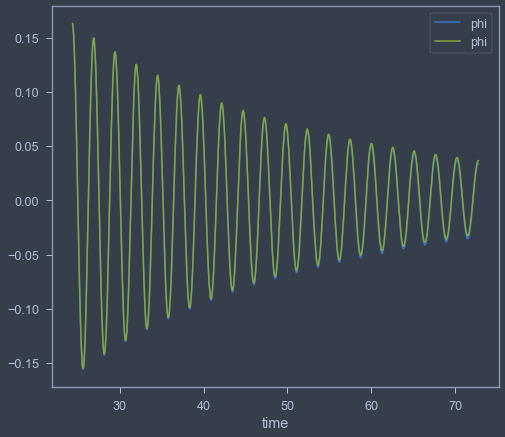

In [17]:
fig,ax=plt.subplots()
X.plot(y='phi', ax=ax)
X_trans.plot(y='phi', ax=ax)

In [18]:
estimator_cubic = EstimatorCubic(fit_method='derivation')
estimator_quadratic_b = EstimatorQuadraticB(fit_method='derivation', maxfev=1000)

In [19]:
steps = [
    ('filter',lowpass_filter),
    ('cutter', cutter), 
    ('offset_transformer',offset_transformer),
    ('estimator', estimator_cubic)
]

pipline_cubic = Pipeline(steps=steps)

In [20]:
steps = [
    ('filter',lowpass_filter),
    ('cutter', cutter), 
    ('offset_transformer',offset_transformer),
    ('estimator', estimator_quadratic_b)
]

pipline_quadratic_b = Pipeline(steps=steps)

In [21]:
def calculate_score(pipeline,run):
    
    y_true =  pipeline['estimator'].X[['phi']]
    y_pred = pipeline.predict(X=run.df[['phi']])
    return np.rad2deg(mean_absolute_error(y_true=y_true, y_pred=y_pred['phi']))
    

In [22]:
models = {
    
    'cubic':pipline_cubic,
    'quadratic_b':pipline_quadratic_b,
    
}

In [24]:
for model_name, model in models.items():
    model.fit(X=run.df[['phi']])

## Integration

In [25]:
estimator_quadratic_b = models['quadratic_b']['estimator']
estimator_quadratic_b_int = EstimatorQuadraticB(fit_method='integration', maxfev=100000, p0=estimator_quadratic_b.parameters)

steps = [
    ('filter',lowpass_filter),
    ('cutter', cutter), 
    ('offset_transformer',offset_transformer),
    ('estimator', estimator_quadratic_b_int)
]

pipline_quadratic_b_int = Pipeline(steps=steps)
models['quadratic_b_int'] = pipline_quadratic_b_int

In [26]:
estimator_cubic = models['cubic']['estimator']
estimator_cubic_int = EstimatorCubic(fit_method='integration', maxfev=100000, p0=estimator_cubic.parameters)

steps = [
    ('filter',lowpass_filter),
    ('cutter', cutter), 
    ('offset_transformer',offset_transformer),
    ('estimator', estimator_cubic_int)
]

pipline_cubic_int = Pipeline(steps=steps)
models['cubic_int'] = pipline_cubic_int

In [27]:
for model_name, model in models.items():
    model.fit(X=run.df[['phi']])

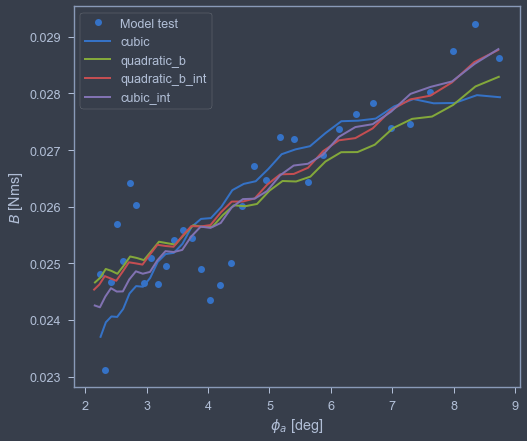

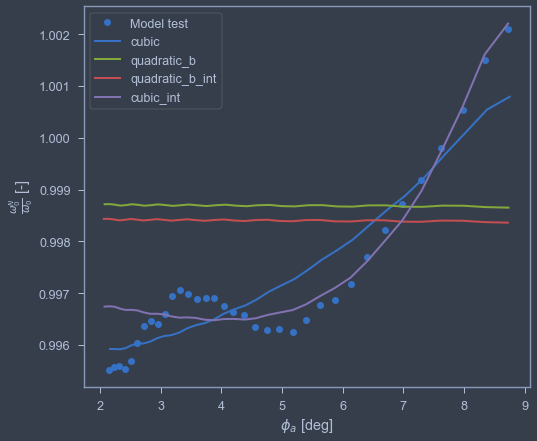

In [28]:
fig,ax=plt.subplots()
include_model_test=True
for model_name, model in models.items():
    
    estimator = model['estimator']
    estimator.plot_damping(ax=ax, include_model_test=include_model_test, label=model_name)
    if include_model_test:
        include_model_test=False
    
fig,ax=plt.subplots()
include_model_test=True
for model_name, model in models.items():
    
    estimator = model['estimator']
    estimator.plot_omega0(ax=ax, include_model_test=include_model_test, label=model_name)
    if include_model_test:
        include_model_test=False

In [30]:
df_summary = pd.DataFrame()

for model_name, model in models.items():
    
    estimator = model['estimator']
    s = pd.Series(name=model_name, data=estimator.parameters)
    s['MEA'] = calculate_score(pipeline=model, run=run)    
    s['score'] = model.score(X=run.df)   
    
    df_summary=df_summary.append(s)
    
    

In [31]:
df_summary.sort_values(by='MEA', inplace=True)

Text(0, 0.5, 'MAE [deg]')

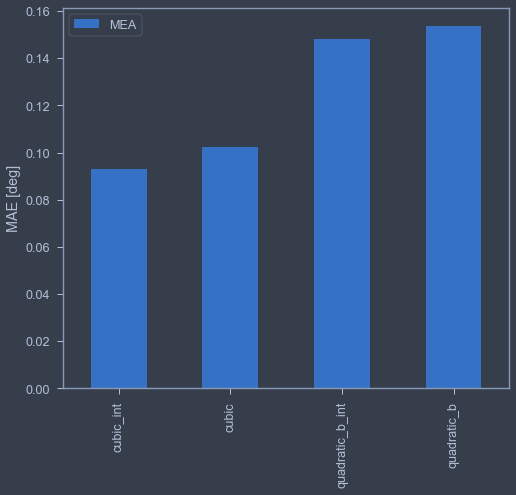

In [32]:
fig,ax=plt.subplots()
df_summary.plot(y='MEA', kind='bar', ax=ax)
ax.set_ylabel('MAE [deg]')

In [33]:
min = df_summary - df_summary.min()
df_summary_normalized = min/min.abs().max()

<AxesSubplot:>

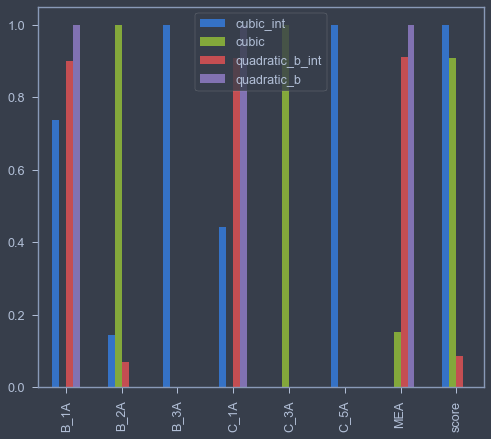

In [34]:
df_summary_normalized.transpose().plot(kind='bar')

## Study influence of offset

In [35]:
estimator_cubic = models['cubic']['estimator']
estimator_cubic_int = EstimatorCubic(fit_method='integration', maxfev=100000, p0=estimator_cubic.parameters)

steps = [
    ('filter',lowpass_filter),
    ('cutter', cutter), 
    ('offset_transformer',offset_transformer),
    ('estimator', estimator_cubic_int)
]

model = Pipeline(steps=steps)

In [36]:
estimator_cubic_int = EstimatorCubic(fit_method='integration', maxfev=100000, p0=estimator_cubic.parameters)

steps = [
    ('filter',lowpass_filter),
    ('cutter', cutter), 
    ('estimator', estimator_cubic_int)    
]

new_model = Pipeline(steps=steps)

In [42]:
df_summary_offset = pd.DataFrame()

model.fit(run.df)
s = pd.Series(name='without offset', data = model['estimator'].parameters)
df_summary_offset['without offset'] = s

new_model.fit(run.df)
s = pd.Series(name='with offset', data = new_model['estimator'].parameters)
df_summary_offset['with offset'] = s
df_summary_offset=df_summary_offset.transpose()

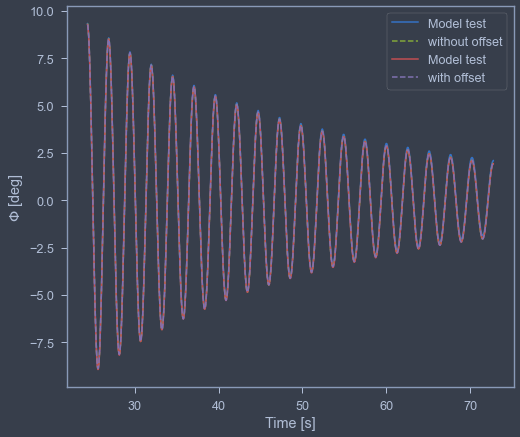

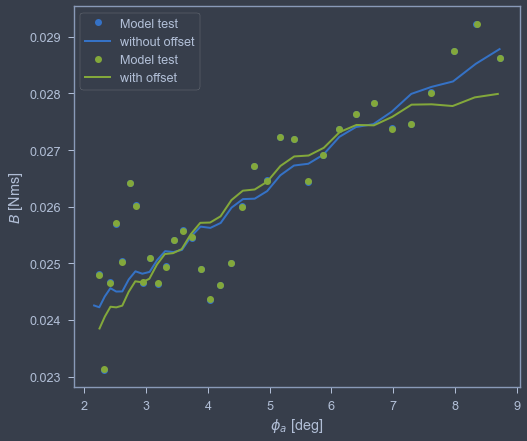

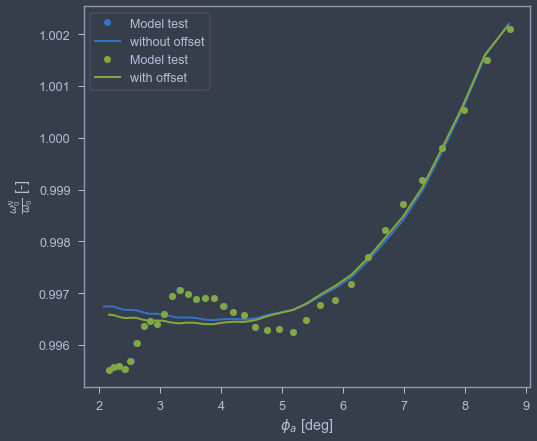

In [43]:
fig,ax=plt.subplots()
model['estimator'].plot_fit(ax=ax, label='without offset')
new_model['estimator'].plot_fit(ax=ax, label='with offset')

fig,ax=plt.subplots()
model['estimator'].plot_damping(ax=ax, label='without offset')
new_model['estimator'].plot_damping(ax=ax, label='with offset')

fig,ax=plt.subplots()
model['estimator'].plot_omega0(ax=ax, label='without offset')
new_model['estimator'].plot_omega0(ax=ax, label='with offset')

<AxesSubplot:xlabel='time'>

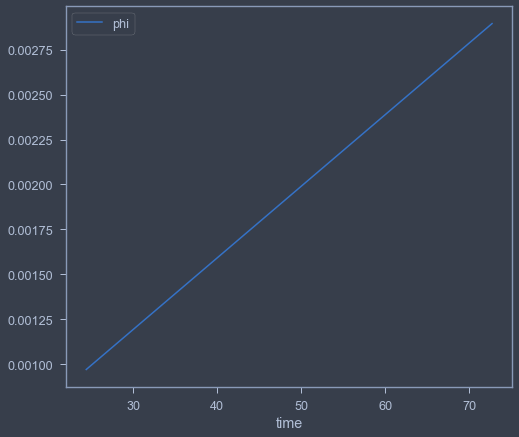

In [44]:
fig,ax=plt.subplots()
diff = model['estimator'].X-new_model['estimator'].X
diff.plot(y='phi', ax=ax) 

In [45]:
df_summary_offset = df_summary_offset[sorted(df_summary_offset.columns)]

<AxesSubplot:>

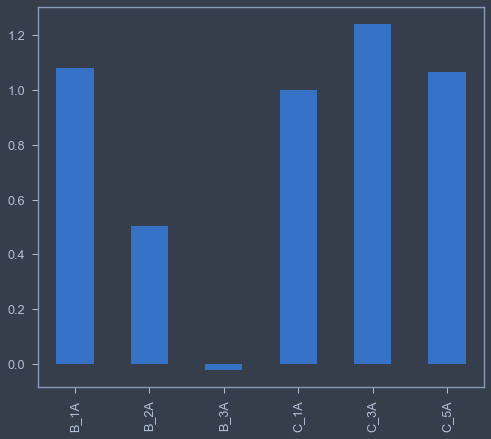

In [46]:
df = df_summary_offset.transpose()
(df['without offset']/df['with offset']).plot(kind='bar')

In [50]:
estimator = model['estimator']
scale_factor = run.model.scale_factor
Disp = run.loading_condition.Volume/(scale_factor**3)
meta_data = {
    'Volume' : Disp,
    'GM': run.loading_condition.gm/scale_factor,
    'rho':1000,
    'g':9.81,
}
result = estimator.result_for_database(meta_data=meta_data)
result

{'B_1A': 0.05572816255903828,
 'C_1A': 6.088581786630572,
 'C_5A': 396.2043043982505,
 'B_2A': 0.052059665699861354,
 'B_3A': 0.0028872687639410264,
 'C_3A': -3.1821136978002516,
 'score': 0.9992140495309593,
 'phi_start': 0.16293739741722763,
 'phi_stop': 0.036667136224551956,
 'omega0_fft': 2.4755750032144674,
 'A_44': 135.00020704200577,
 'B_1': 7.52331348354072,
 'C_1': 821.959801787313,
 'C_5': 53487.6631246977,
 'B_2': 7.02806564801889,
 'B_3': 0.389781880917955,
 'C_3': -429.586008034237,
 'omega0': 2.4675051745904346}

In [51]:
joblib.dump(model, '../models/KVLCC2_speed.pkl')

['../models/KVLCC2_speed.pkl']

In [52]:
np.rad2deg(estimator.X.iloc[0]['phi'])

9.335625196852943

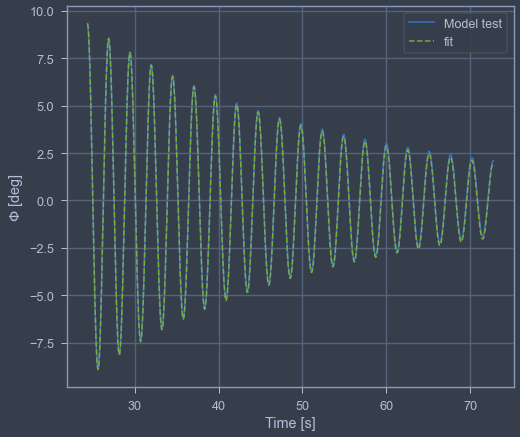

In [53]:
fig,ax=plt.subplots()
estimator.plot_fit(ax=ax)
ax.grid(True)


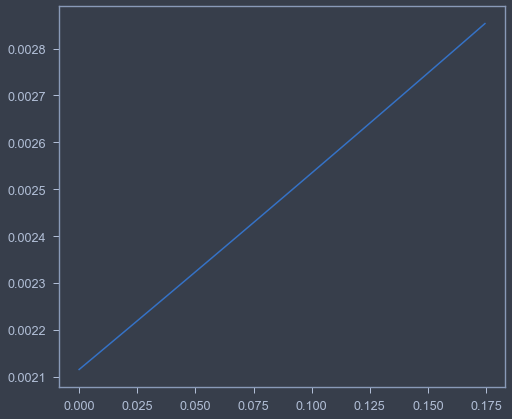

In [54]:
phi_as = np.deg2rad(np.linspace(0,10,100))
B_es = lambdas.B_e_lambda_cubic(B_1=result['B_1'], B_2=result['B_2'], B_3=result['B_3'], omega0=result['omega0'], phi_a=phi_as)
beam = run.ship.beam/scale_factor
g = 9.81
rho = 1025
B_es_hat = lambdas.B_e_hat_lambda(B_e=B_es, Disp=Disp, beam=beam, g=g, rho=rho)
fig,ax=plt.subplots()
ax.plot(phi_as, B_es_hat)
